# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2-4 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.


For sumbission, you need to submit
 - this notebook (.ipynb file) with all cell outputs
 - an exported PDF version with cell outputs of this notebook

You need to check that cell outputs are included in your PDF file \(sometimes the outputs will not be properly shown when exporting\), and then put them in the same ZIP file and submit to Homework 2-programming on Gradescope.



### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [2]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt

## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [3]:
#from os import O_SEQUENTIAL
class Value:

    """
    Basic unit of storing a single scalar value and its gradient
    """

    def __init__(self, data, _children=()):
        """

        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None

    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)

        Args:
            other (Any): Node to add with the class

        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        #Convert default value type to Value
        other = other if isinstance(other, Value) else Value(other)

        #Create a new Value object with multiplied value
        out = Value(self.data * other.data, (self, other))

        #_backward function will pass the coefficient times the gradient from children nodes
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        #TODO implement power operation, we don't need to convert the exponent to Value
        assert isinstance(other, (int, float))

        #Create a new Value object with multiplied value
        out = Value(pow(self.data, other), {self})

        #_backward function will pass polynomial derivative from children node
        def _backward():
          if other == 1:
            self.grad = out.grad
          elif other == 0:
            self.grad = 0
          else:
            self.grad += out.grad * (other * pow(self.data, other-1))
        out._backward = _backward

        return out

    def relu(self):
        """
        ReLU activation function applied to the current Value
        """
        #TODO implement the relu activation function for the value itself.
        out = Value(max(self.data, 0), (self,))

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        out._backward = _backward

        return out


    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """
        #TODO implement the exponential function for and treat the value as exponent.
        #The base is natural e, you can use numpy to calculate the value of the exponential.

        #Create a new Value object with exp-ed value
        #float128 to avoid overflow
        exp_val = np.exp(np.float128(self.data))
        out = Value(exp_val, (self,))

        #_backward function will pass exp derivative to children node
        def _backward():
          self.grad += out.grad * exp_val
        out._backward = _backward

        return out

    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """
        #TODO implement the logarithm function for and treat the value as exponent.
        #The bottom number should be e, you can use numpy to calculate the value of the logarithm.

        #Create a new Value object with log-ed value
        out = Value(np.log(self.data), {self})

        #_backward function will pass log derivative to children node
        def _backward():
          self.grad += out.grad * (1/self.data)
        out._backward = _backward

        return out


    def topoSort(self, topo, visited):
      for nodes in self._prev:
        if not nodes in visited:
          nodes.topoSort(topo, visited)
      topo.insert(0, self)
      visited.add(self)



    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm
        """ using stack is computationally expansive, making the runtime increased severely
        def topoSort(value, visited, stack):
          visited.append(value)
          for node in value._prev:
            if node not in visited:
              topoSort(node, visited, stack)
          stack.append(0, value)

        def topoList(value, topo):
          stack = []
          visited = []
          topoSort(value, visited, stack)
          while(len(stack) != 0):
            v = stack.pop()
            topo.append(v)
        """

        topo = []
        visited = []
        #TODO find the right list of Value to be traversed
        '''
        Hint: you can recursively visit all non-visited node from the node calling backward.
        add one node to the head of the list after all of its children node are visited
        '''
        self.topoSort(topo, set())

        #topoSort(self, visited, topo)

        #go one variable at a time and apply the chain rule to get its gradient
        for v in topo:
            v._backward()

    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other

    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)

    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)

    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1

    def __repr__(self):
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

    # extra function to make Value object comparable for finding the max
    def __gt__(self, other):
        return self.data > other.data

Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation.

In [4]:
nodes = []
## Initialize Example Values (From Written Assignment)
w1 = Value(0.2)
w2 = Value(0.4)
x1 = Value(-0.4)
x2 = Value(0.5)

# Initialize the computational graph
multiply1 = w1.__mul__(x1)
multiply2 = w2.__mul__(x2)
plus1 = multiply1.__add__(multiply2)
multiply3 = plus1.__mul__(-1)
exp1 = multiply3.exp()
plus2 = exp1.__add__(1)
pow1 = plus2.__pow__(-1)
pow2 = w1.__pow__(2)
pow3 = w2.__pow__(2)
plus3 = pow2.__add__(pow3)
multiply4 = plus3.__mul__(0.5)
plus4 = pow1.__add__(multiply4)
nodes.append(multiply1)
nodes.append(multiply2)
nodes.append(multiply3)
nodes.append(multiply4)
nodes.append(plus1)
nodes.append(plus2)
nodes.append(plus3)
nodes.append(exp1)

# Calculate back propagation
plus4.backward()


#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.
for item in nodes:
  print(item)

print("w1",w1)
print("w2",w2)
print("x1",x1)
print("x2",x2)


Value(data=-0.08000000000000002, grad=0.24910215560185006)
Value(data=0.2, grad=0.24910215560185006)
Value(data=-0.12, grad=-0.24910215560185006)
Value(data=0.10000000000000002, grad=1.0)
Value(data=0.12, grad=0.24910215560185006)
Value(data=1.8869204367171575, grad=-0.28086189616272167)
Value(data=0.20000000000000004, grad=0.5)
Value(data=0.8869204367171575, grad=-0.28086189616272167)
w1 Value(data=0.2, grad=0.10035913775925998)
w2 Value(data=0.4, grad=0.524551077800925)
x1 Value(data=-0.4, grad=0.04982043112037002)
x2 Value(data=0.5, grad=0.09964086224074004)


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.


In [5]:
from re import M
class Module:

    """
    Base Model Module
    """

    def parameters(self):
        """

        """
        return []

    def zero_grad(self):
        """

        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):

    """
    Linear Layer
    """

    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0

        You may use this stucture to implement the __call__ function
        """
        self.w = []
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)
        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO implement this function and return the output of a linear layer.
        xout = np.matmul(np.array(x), np.array(self.w)) + np.array(self.b)

        return xout.tolist()


    def parameters(self):
        """
        Get the list of parameters in the Linear Layer

        Args:
            None

        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [6]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)],
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)],
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)],
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print(predict_error.data)

0.0


### Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [7]:
def softmax(y_hat):
    """
    Softmax computation

    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]

    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat
    """
    #TODO implement the softmax function and return the output.
    row = len(y_hat)
    col = len(y_hat[0])

    #Initialize s as the output matrix
    s = [[0 for c in range(col)] for r in range(row)]

    for i in range(len(y_hat)):
      exp_sum = sum(np.exp(y_hat[i]))
      for j in range(len(y_hat[i])):
        s[i][j] += np.exp(y_hat[i][j]) / exp_sum

    return s

In [8]:
def cross_entropy_loss(y_hat, y, softOut):
    """
    Cross-entropy Loss computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ], where each entry
        is the index of the true class label for the corresponding sample in the batch.
        softOut: softmax(y_hat), passed in here because the accuracy() function also uses softOut,
        intended to reduce computation demand

    Returns:
        loss (Value): Loss value of type Value
    """
    #TODO implement the calculation of cross_entropy_loss between y_hat and y.
    #Initialize loss
    loss = 0
    #softOut = softmax(y_hat)
    for i in range(len(y)):
      loss += -np.log(softOut[i][y[i]])

    #Initialize loss as output value
    return loss / len(y)

In [9]:
def accuracy(y_hat, y, softOut):
    """
    Accuracy computation. Accuracy is defined as the ratio of correctly classified samples
    to the total number of samples in the entire batch.

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ], where each entry
        is the index of the true class label for the corresponding sample in the batch.
        softOut: softmax(y_hat), passed in here because the cross_entropy_loss() function also uses softOut,
        intended to reduce computation demand

    Returns:
        acc (float): Accuracy score
    """
    #TODO implement the calculation of accuracy of the predicted y_hat w.r.t y.
    #Initialize acc as the accuracy score
    acc = 0

    #softOut = softmax(y_hat)

    for i in range(len(y_hat)):
        if softOut[i].index(max(softOut[i])) == y[i]:
          acc += 1
    return acc / len(y)

Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [10]:
## Ground Truth + Forward Pass
y_gt = [1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt, prob_test)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479],
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107],
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089],
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

1.4466769027129063634e-32
1.9228325529030421137e-16
1.7772781619607712213e-32
8.983134900317125301e-33


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [11]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image:

    Args:
        X (np.ndarray): 2D array containing the coordinates of data points (Ex:[[x1, y1], [x2, y2], ...]
        Y (np.ndarray): 1D array containing the labels of the points.(Ex: [1, 3, 1, 2, 2])
        scale (float): the scale for x and y coordinates. The output x-axis will range from -scale to +scale
        n (int): The dimensionality of the output image in pixels (n x n).
        data (np.ndarray):  3D array representing the image data (n x n x 3).

    Output:
        data (np.ndarray): updated data array with the points plotted.
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]

    for i in range(X.shape[0]):
        #TODO Assign a color to "data" according to the position and the label of X
        ind = (X[i]+scale) * n / (2*scale)
        tag = int(Y[i])
        data[int(ind[0])][int(ind[1])] = points_color[tag]

    return data


def plot_background(scale, n, model):
    """
    Color the background in the visualization image

    Args:
        scale (float): The scale for x and y coordinates.
        n (int): The dimensionality of the output image in pixels (n x n).
        model (object): The machine learning model used for predictions.

    Output:
        data (np.ndarray): The data array with the background colored based on model predictions (n x n x 3).

    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]

    data = np.zeros((n,n,3), dtype='uint8')

    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            #TODO using the model to predict a class for the input and assign a color to "data" at this position.
            out = model(input)[0]
            classOut = out.index(max(out))
            data[i][j] = background_color[classOut]
    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization

     Args:
        X (np.ndarray): 2D array containing the coordinates of data points (Ex:[[x1, y1], [x2, y2], ...]
        Y (np.ndarray): 1D array containing the labels of the points.(Ex: [1, 3, 1, 2, 2])
        model (object): The machine learning model used for predictions.

    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)

    plt.imshow(data)
    plt.axis('off')
    plt.show()

if you implement the plot function correctly, you will get some image like:

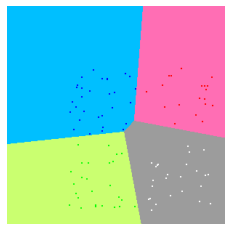


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

In [12]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss,
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """
    for i in range(max_iteration):
        #TODO compute y_hat and calculate the loss between y_hat and y as well as
        # the accuracy of y_hat w.r.t y.
        y_hat = model(x)
        softOut = softmax(y_hat)
        loss = cross_entropy_loss(y_hat, y, softOut)
        acc = accuracy(y_hat, y, softOut)

        #TODO Then You will need to calculate gradient for all parameters, and
        #do gradient descent for all the parameters.
        #The list of parameters can be easily obtained by calling
        #model.parameters() which is implemented above.
        #learning_rate = 0.8

        #zero gradients to avoid overflow
        model.zero_grad()
        loss.backward()
        for pars in model.parameters():
            pars.data = pars.data - learning_rate * pars.grad


        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)

    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


### Train the model

Load the data, format it, instantiate your model and start training!

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 0.58123309565089834906 accuracy: 0.95
iteration 39 loss: 0.42394392238503492587 accuracy: 0.96
iteration 59 loss: 0.3512730476359276105 accuracy: 0.97
iteration 79 loss: 0.30688572445085788283 accuracy: 0.98
iteration 99 loss: 0.27607628155685996193 accuracy: 0.98
iteration 119 loss: 0.25303590853285242912 accuracy: 0.98
iteration 139 loss: 0.23493655810304514848 accuracy: 0.99
iteration 159 loss: 0.22021178402217319651 accuracy: 0.99
iteration 179 loss: 0.20791374660934128018 accuracy: 0.99
iteration 199 loss: 0.19743058533032428766 accuracy: 0.99
iteration 219 loss: 0.18834725099238292855 accuracy: 0.99
iteration 239 loss: 0.1803709162160504762 accuracy: 0.99
iteration 259 loss: 0.17328827251702174474 accuracy: 0.99
iteration 279 loss: 0.16693975458205866432 accuracy: 0.99
iteration 299 loss: 0.161203291000121656

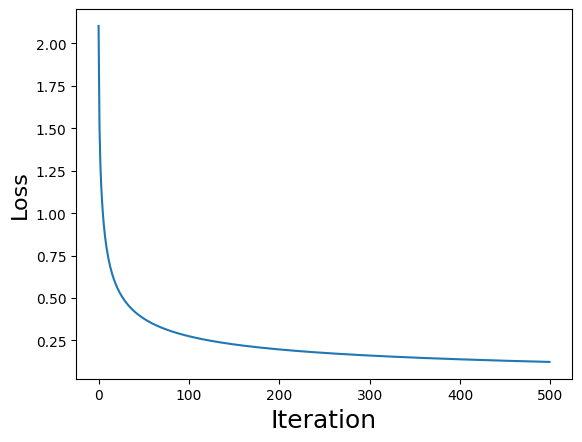

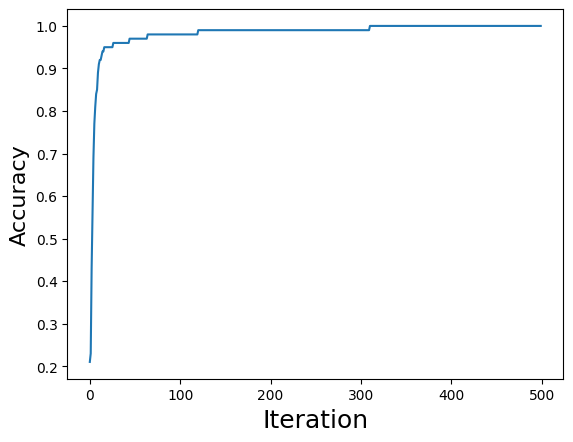

In [13]:
## Load Q3 Dataset
""" Load data set from google drive
datapath = './Q3_data.npz'
data = np.load(datapath)
"""

from google.colab import drive
drive.mount('/content/drive')
datapath = '/content/drive/MyDrive/Colab Notebooks/Q3_data.npz'
data = np.load(datapath)

## Load Data and Parse Shape Information
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model)

In [ ]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [17]:
## Load Q4 Dataset
""" Load data set from google drive
drive.mount('/content/drive')
datapath = '/content/drive/MyDrive/Colab Notebooks/Q4_data.npz'
data = np.load(datapath)
"""
datapath = './Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1]
nout = int(np.max(Y)) + 1

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

Mounted at /content/drive


iteration 19 loss: 0.377877663164001822 accuracy: 0.8
iteration 39 loss: 0.3579064793844076328 accuracy: 0.825
iteration 59 loss: 0.35031085157303472796 accuracy: 0.825
iteration 79 loss: 0.34602349246465363675 accuracy: 0.825
iteration 99 loss: 0.34322875343658537875 accuracy: 0.825
iteration 119 loss: 0.34126836499773255176 accuracy: 0.825
iteration 139 loss: 0.33982988998469618546 accuracy: 0.825
iteration 159 loss: 0.33874181363606921603 accuracy: 0.825
iteration 179 loss: 0.33790067432604455776 accuracy: 0.85
iteration 199 loss: 0.33723969051157987004 accuracy: 0.85
iteration 219 loss: 0.33671353612292026841 accuracy: 0.85
iteration 239 loss: 0.33629026787177916538 accuracy: 0.85
iteration 259 loss: 0.33594672335132315014 accuracy: 0.85
iteration 279 loss: 0.33566573389183787694 accuracy: 0.85
iteration 299 loss: 0.33543434988607017985 accuracy: 0.85
iteration 319 loss: 0.33524266401867601622 accuracy: 0.85
iteration 339 loss: 0.33508300525512428028 accuracy: 0.85
iteration 359 lo

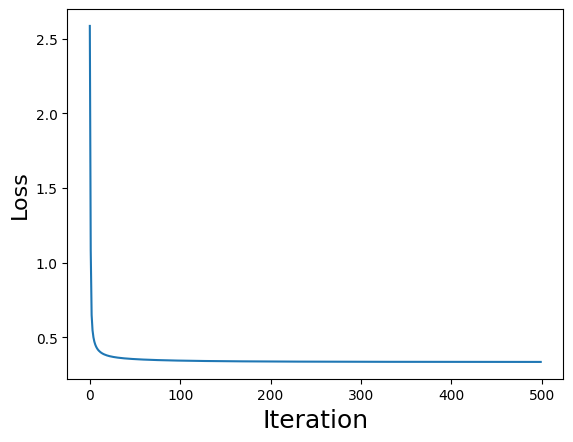

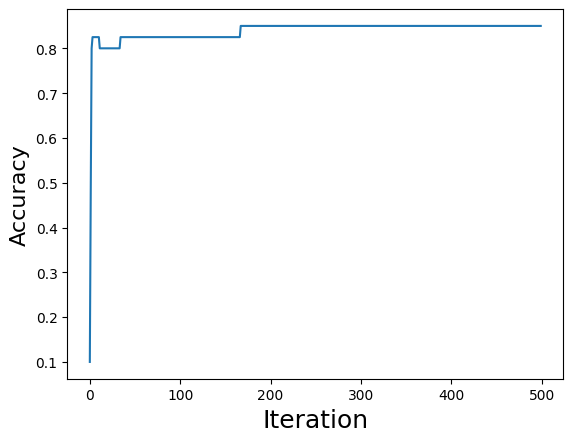

In [18]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model)

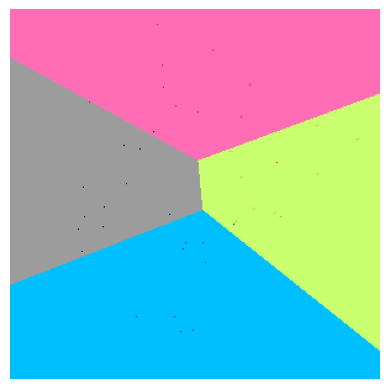

In [19]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [22]:
class MLP(Module):

    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        def activate(xout):
          for a in range(len(xout)):
              for b in range(len(xout[0])):
                xout[a][b] = xout[a][b].relu()

        #TODO Implement this function and return the output of a MLP
        xout = x.copy()

        for i in range(len(self.linear_layers)):
          # x comes in originally for the first layer
          if i == 0:
              xout = self.linear_layers[i](xout)
          # for the output layer, xout is softmax-ed
          elif i == len(self.linear_layers)-1:
                xout = self.linear_layers[i](softmax(xout))
          # for each hidden layer, xout is passed after activated
          else:
              activate(xout)
              xout = self.linear_layers[i](xout)
        return xout

    def parameters(self):
        """
        Get the parameters of each layer

        Args:
            None

        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]

    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 0.9695379894154949413 accuracy: 0.775
iteration 39 loss: 0.69898868897717492853 accuracy: 0.85
iteration 59 loss: 0.5493028055641109709 accuracy: 0.85
iteration 79 loss: 0.4565208179471656796 accuracy: 0.875
iteration 99 loss: 0.40532499451513076676 accuracy: 0.875
iteration 119 loss: 0.37352446137061929538 accuracy: 0.875
iteration 139 loss: 0.3503666728274459549 accuracy: 0.875
iteration 159 loss: 0.3325117663904728157 accuracy: 0.875
iteration 179 loss: 0.31912871422945977677 accuracy: 0.9
iteration 199 loss: 0.30920925219597599154 accuracy: 0.9
iteration 219 loss: 0.30163379720141012688 accuracy: 0.9
iteration 239 loss: 0.29556347119656431384 accuracy: 0.9
iteration 259 loss: 0.2904602709312385829 accuracy: 0.9
iteration 279 loss: 0.28598800820934375898 accuracy: 0.9
iteration 299 loss: 0.28193122265739983774 accuracy: 0.9
iteration 319 loss: 0.27814732203805263449 accuracy: 0.9
iteration 339 loss: 0.27454081342850994 accuracy: 0.9
iteration 359 loss: 0.271050689

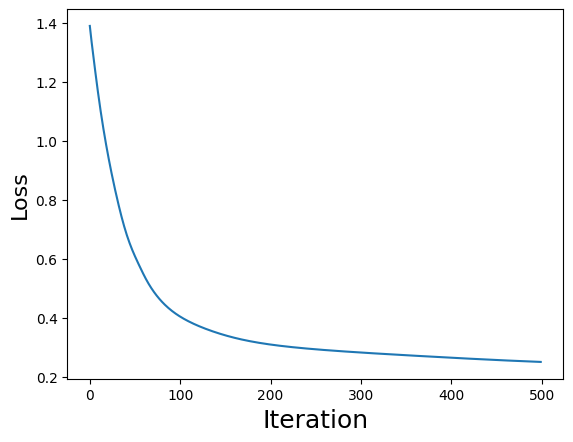

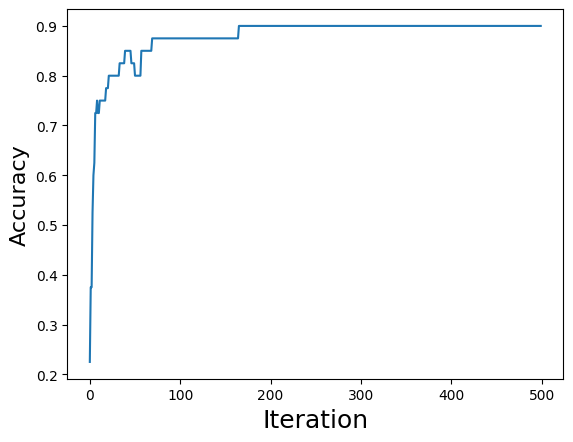

In [23]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model)

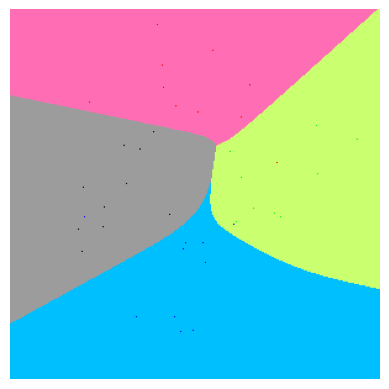

In [24]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd